In [ ]:
! pip install datasets

In [ ]:
from datasets import load_dataset

ds = load_dataset("fka/awesome-chatgpt-prompts")

In [ ]:
ds

# Loading a custom dataset

You can use the Hugging Face Hub to download datasets, but you’ll often find yourself working with data that is stored either on your laptop or on a remote server.

The Datasets library provides loading scripts to handle the loading of local and remote datasets. It supports several common data formats.

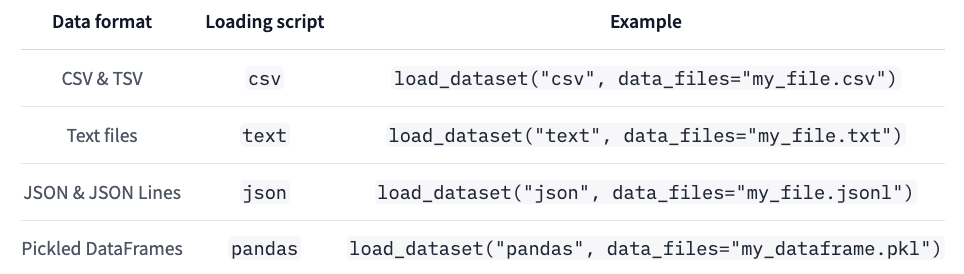

For each data format we just need to specify the type of data format in the `load_dataset()` function, along with a `data_files` argument that specifies the path to one or more files.

## Loading a local CSV dataset

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [ ]:
from datasets import load_dataset

local_csv_dataset = load_dataset("csv", data_files="winequality-white.csv", sep=";")
local_csv_dataset["train"]

## Load from the Internet

In [ ]:
# Load the dataset from the URL directly
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
remote_csv_dataset = load_dataset("csv", data_files=dataset_url, sep=";")
remote_csv_dataset

### Raw Text

In [ ]:
dataset_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text_dataset = load_dataset("text", data_files=dataset_url)

In [ ]:
text_dataset

In [ ]:
text_dataset["train"]

In [ ]:
text_dataset["train"][:50]

### JSONs

In [ ]:
dataset_url = "https://raw.githubusercontent.com/hirupert/sede/main/data/sede/train.jsonl"
json_lines_dataset = load_dataset("json", data_files=dataset_url)
json_lines_dataset["train"][:2]

If you have more than one split:

In [ ]:
url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/"
data_files = {"train": f"{url}train-v2.0.json", "test": f"{url}dev-v2.0.json"}
json_dataset = load_dataset("json", data_files=data_files, field="data")
json_dataset

# Preprocessing your Data

The dataset library allows you to preprocess your dataset in many ways:

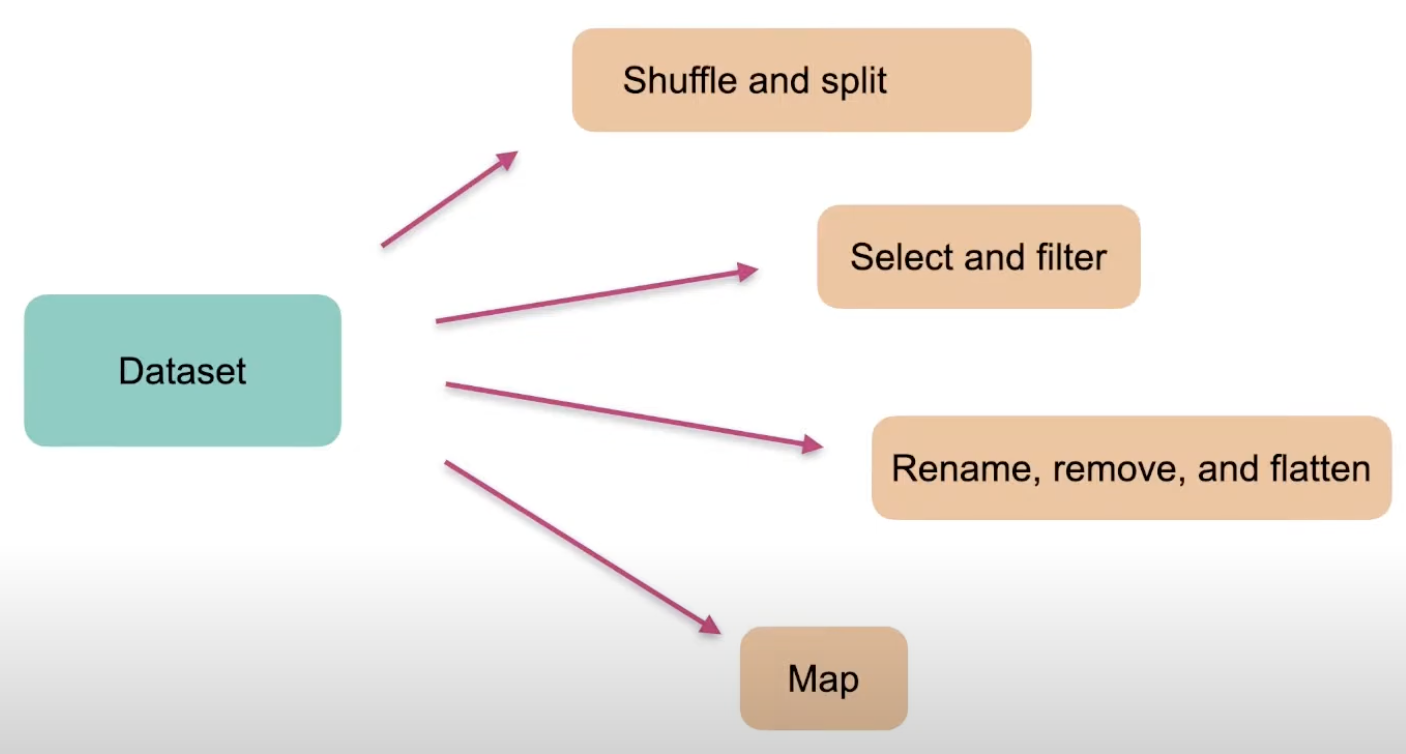

## Shuffle your dataset

Generally a good idea to shuffle your training set so that your model does not learn any artificial ordering of your data.

In [ ]:
from datasets import load_dataset

squad = load_dataset("squad", split="train")
squad[0]

In [ ]:
squad_shuffled = squad.shuffle(seed=42)
squad_shuffled[0]

# Dataset Splits

Think of this as another way to shuffle your data.

In [ ]:
help(squad.train_test_split)

In [ ]:
dataset = squad_shuffled.train_test_split(test_size=0.1, seed=42)
dataset

## The `select` Method

Expects an input of a list or a generator of indices and returns a Dataset object containing the subset of just those rows.

In [ ]:
indices = [0, 10, 20, 40, 80]
type(squad[indices])

**NOTICE the difference between the output data type.**

In [ ]:
indices = [0, 10, 20, 40, 80]
examples = squad.select(indices)
examples

Another quick usecase of select is to create a random sample of rows (when combined with `shuffle`).

In [ ]:
sample = squad.shuffle().select(range(5))
sample

## The `filter` method

Returns rows that match a condition(s).

In [ ]:
def startsWithL(x):
  if x["title"].startswith("L"):
    return True
  else:
    return False

In [ ]:
squad_filtered = squad.filter(startsWithL)
squad_filtered

In [ ]:
# same
squad_filtered = squad.filter(lambda x : x["title"].startswith("L"))
squad_filtered[0]

In [ ]:
# function chaining is something we can use effectively!
squad.filter(startsWithL).shuffle(seed=42).select(range(5))

## Column Transformations

Rename Columns

In [ ]:
help(squad.rename_column)

In [ ]:
# works on one column at a time only; does not work inplace, explicit assignment is required
squad = squad.rename_column("context", "passages").rename_column("id", "index").rename_column("question", "query")

Remove Columns

In [ ]:
squad.remove_columns(["index", "title"])

Flatten nested columns in to separate columns

In [ ]:
from datasets import load_dataset

squad = load_dataset("squad", split="train")
squad

In [ ]:
squad[0]

In [ ]:
squad.flatten()[0]

# The `map` method

Applies a (custom) processing function to each row in the Dataset.

In [ ]:
def lowercase_title(example):
    return {"title": example["title"].lower()}

squad_lowercase = squad.map(lowercase_title)
# Peek at random sample
squad_lowercase.shuffle(seed=42)["title"][:5]

The `map` method can also be applied on batches of rows.

This is, especially, useful for tokenization. The `AutoTokenizer` library, for instance, can do multi-threading and parallelization for faster results.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_title(example):
    return tokenizer(example["title"])

squad.map(tokenize_title, batched=True, batch_size=500)

## Creating new columns


In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

In [ ]:
drug_dataset = drug_dataset.remove_columns("Unnamed: 0")

In [ ]:
def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

In [ ]:
drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

As expected, we can see a review_length column has been added to our training set. We can sort this new column with `Dataset.sort()` to see what the extreme values look like:

In [ ]:
drug_dataset["train"].sort("review_length")[:3]

## From `Datasets` to `DataFrames` and back

Although the processing functions of `Datasets` will cover most of your model training needs, there may be times when you’ll need to switch to Pandas to access more powerful features, like `DataFrame.groupby()` or high-level APIs for visualization. Fortunately, `Datasets` is designed to be interoperable with libraries such as Pandas, NumPy, PyTorch, TensorFlow, and JAX. Let’s take a look at how this works.



To enable the conversion between various third-party libraries, `Datasets` provides a `Dataset.set_format()` function. This function only changes the output format of the dataset, so you can easily switch to another format without affecting the underlying data format, which is Apache Arrow. The formatting is done in place. To demonstrate, let’s convert our dataset to Pandas:

In [ ]:
from datasets import load_dataset

dataset = load_dataset("swiss_judgment_prediction", "all", split="train")
dataset[0]

In [ ]:
# Convert the output format to pandas.DataFrame, it happens inplace
dataset.set_format("pandas")
dataset[0]

In [ ]:
type(dataset)

Or, you can use the `to_pandas` method to change the data.

In [ ]:
df = dataset.to_pandas()
df.head()

In [ ]:
# How are languages distributed across regions?
df.groupby("region")["language"].value_counts()

In [ ]:
# Which legal area is most common?
df["legal area"].value_counts()

Just remember to reset the format when you are finished, otherwise you may see errors!

In [ ]:
from transformers import AutoTokenizer

# Load a pretrained tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# Tokenize the `text` column
dataset.map(lambda x : tokenizer(x["text"]))

In [ ]:
# Reset format
dataset.reset_format()
# Now we can tokenize!
dataset.map(lambda x : tokenizer(x["text"]))

# Saving & Loading a Dataset

The Datasets library will cache every downloaded dataset and the operations performed on it.

The cache allows Dataset library to avoid re-downloading or re-processing the entire dataset (which is a good thing).

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("allocine")
raw_datasets.cache_files # each split will have a filename.

Alternatively, you can store your dataset in a different location and format.

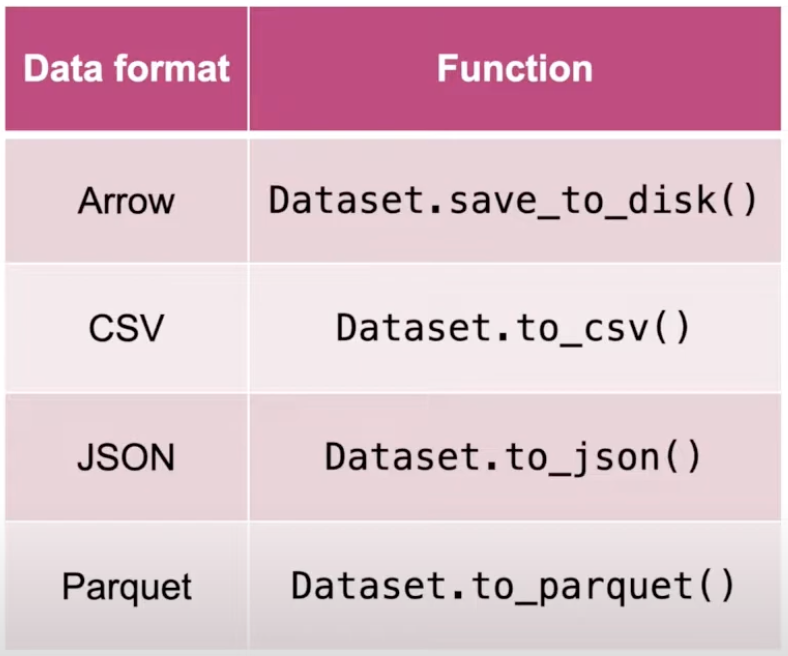

CSV and JSON formats are good for small to medium sized datasets.
For huge datasets, use parquet or arrow formats.

When you save to arrow format (which is the default format), each split and its metadata is stored in a separate directory.

In [ ]:
raw_datasets.save_to_disk("my-arrow-datasets")

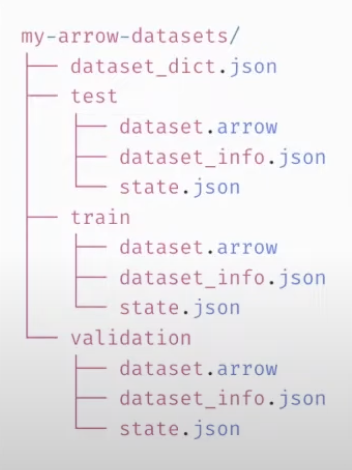

In [ ]:
from datasets import load_from_disk

arrow_datasets_reloaded = load_from_disk("my-arrow-datasets")
arrow_datasets_reloaded

For the CSV format, we have to store each split as a separate file. One way to do this is by iterating over the keys and values in the `DatasetDict` object:

In [ ]:
for split, dataset in raw_datasets.items():
    dataset.to_csv(f"my-dataset-{split}.csv", index=None)

Use the `load_dataset` with the `data_files` parameter to load:

In [ ]:
data_files = {
    "train": "my-dataset-train.csv",
    "validation": "my-dataset-validation.csv",
    "test": "my-dataset-test.csv",
}

csv_datasets_reloaded = load_dataset("csv", data_files=data_files)
csv_datasets_reloaded

Similar approaches for JSONs and Parquets:

In [ ]:
# Save in JSON Lines format
for split, dataset in raw_datasets.items():
    dataset.to_json(f"my-dataset-{split}.jsonl")

# Save in Parquet format
for split, dataset in raw_datasets.items():
    dataset.to_parquet(f"my-dataset-{split}.parquet")

In [ ]:
json_data_files = {
    "train": "my-dataset-train.jsonl",
    "validation": "my-dataset-validation.jsonl",
    "test": "my-dataset-test.jsonl",
}

parquet_data_files = {
    "train": "my-dataset-train.parquet",
    "validation": "my-dataset-validation.parquet",
    "test": "my-dataset-test.parquet",
}

# Reload with the `json` script
json_datasets_reloaded = load_dataset("json", data_files=json_data_files)
# Reload with the `parquet` script
parquet_datasets_reloaded = load_dataset("parquet", data_files=parquet_data_files)